In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')


In [ ]:
df_resume = pd.read_csv('../DataSet/Role-Resume-Dataset.csv')
df_jobs = pd.read_csv('../DataSet/Job-Description-Dataset.csv')

In [ ]:
df_resume.head()

In [ ]:
df_jobs.head()

In [ ]:
df_resume.isnull().sum()

In [ ]:
df_jobs.isnull().sum()

In [ ]:
df_jobs.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df_resume.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df_jobs.columns

In [ ]:
df_resume.columns

In [ ]:
df_jobs.duplicated().sum()

In [ ]:
df_resume.duplicated().sum()

In [ ]:
df_resume['job_title'].value_counts()

In [ ]:
df_jobs['Job Title'].value_counts()

In [ ]:
df_resume['clean_resume'] = df_resume['resume'].str.lower()
df_resume['clean_resume'] = df_resume['clean_resume'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))

In [ ]:
tokenizer = TreebankWordTokenizer()
df_resume['clean_resume'] = df_resume['clean_resume'].apply(tokenizer.tokenize)

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# استفاده از stopwords آماده sklearn
stop_words = set(ENGLISH_STOP_WORDS)

# # افزودن کلمات پرت و نویز که باید حذف شوند
# custom_stopwords = {'like', 'using', 'etc', 'must', 'should', 'will', 'can', 'want', 'get', 'make'}
# stop_words.update(custom_stopwords)


In [ ]:

df_resume['clean_resume'] = df_resume['clean_resume'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [ ]:
df_resume['clean_resume'] = df_resume['clean_resume'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
df_resume_clean = df_resume.drop(columns='resume')
df_resume_clean.head()

In [ ]:
df_jobs['clean_description'] = df_jobs['Job Description'].str.lower()
df_jobs['clean_description'] = df_jobs['clean_description'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', str(x)))
df_jobs['clean_description'] = df_jobs['clean_description'].apply(tokenizer.tokenize)
df_jobs['clean_description'] = df_jobs['clean_description'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df_jobs['clean_description'] = df_jobs['clean_description'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
X = df_resume_clean['clean_resume']
y = df_resume_clean['job_title']

vectorizer = TfidfVectorizer(max_features=5000)
X_vect = vectorizer.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_vect, y_encoded, test_size=0.2, random_state=42)

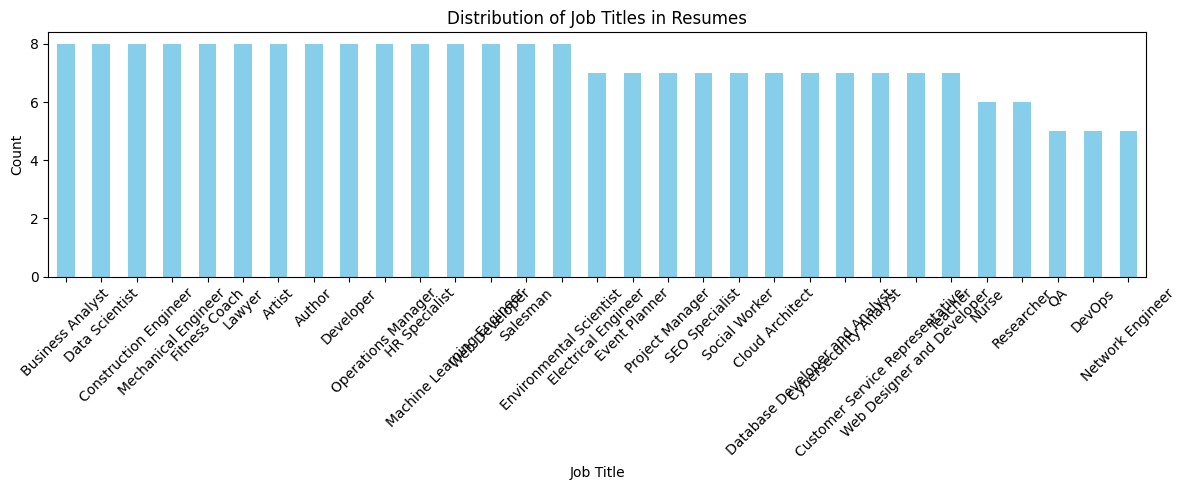

In [63]:
plt.figure(figsize=(12, 5))
df_resume['job_title'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Job Titles in Resumes')
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

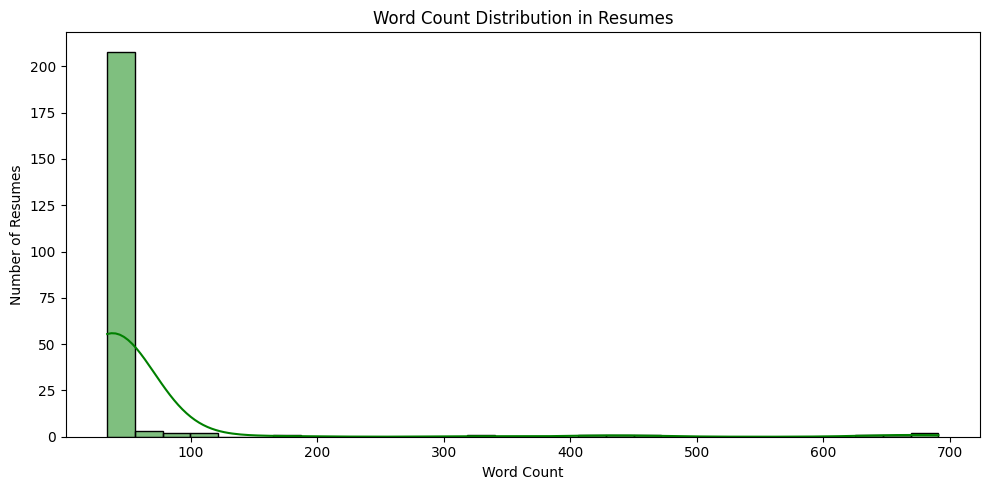

In [64]:
df_resume['resume_word_count'] = df_resume['resume'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(df_resume['resume_word_count'], bins=30, kde=True, color='green')
plt.title('Word Count Distribution in Resumes')
plt.xlabel('Word Count')
plt.ylabel('Number of Resumes')
plt.tight_layout()
plt.show()

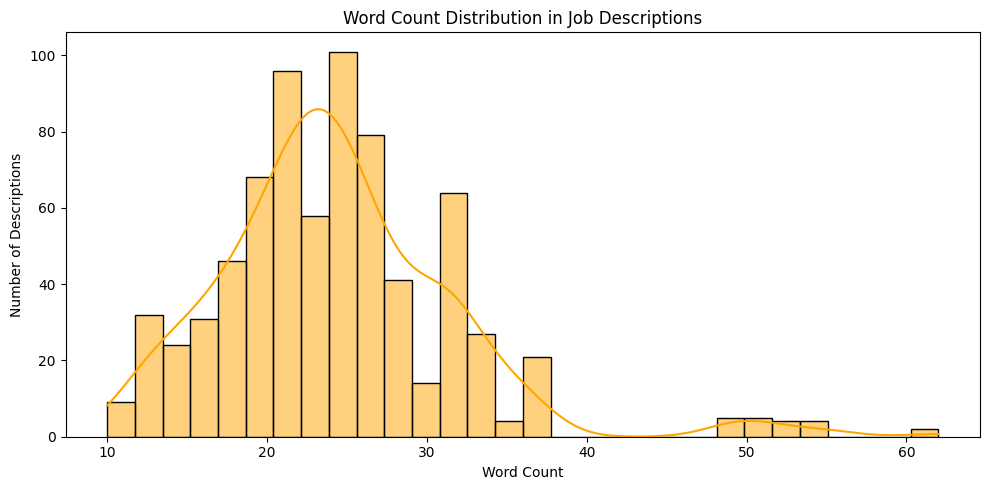

In [65]:
df_jobs['description_word_count'] = df_jobs['Job Description'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(df_jobs['description_word_count'], bins=30, kde=True, color='orange')
plt.title('Word Count Distribution in Job Descriptions')
plt.xlabel('Word Count')
plt.ylabel('Number of Descriptions')
plt.tight_layout()
plt.show()

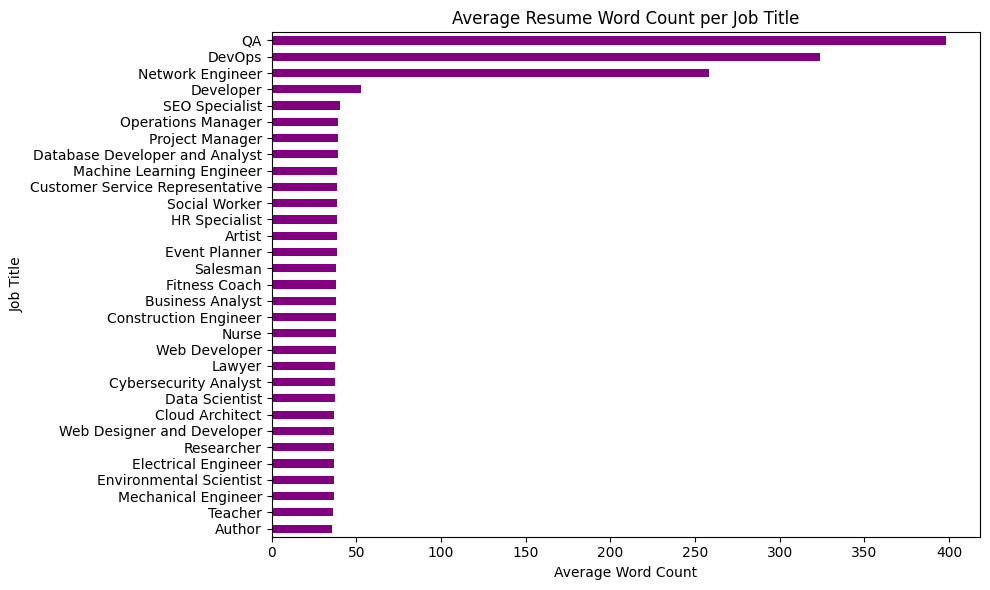

In [66]:
avg_words_per_job = df_resume.groupby('job_title')['resume_word_count'].mean().sort_values()
plt.figure(figsize=(10, 6))
avg_words_per_job.plot(kind='barh', color='purple')
plt.title('Average Resume Word Count per Job Title')
plt.xlabel('Average Word Count')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Model accuracy : ", accuracy_score(y_test, y_pred))
print("Classification report : ", classification_report(y_test, y_pred))

In [ ]:
def get_top_keywords(texts, top_n=30):
    tfidf = TfidfVectorizer(max_features=5000)
    tfidf_matrix = tfidf.fit_transform(texts)
    scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
    words = tfidf.get_feature_names_out()
    top_idx = scores.argsort()[::-1][:top_n]
    return [words[i] for i in top_idx]


def predict_job_and_missing_skills_v2(resume_text):
    cleaned = resume_text.lower()
    cleaned = re.sub(r'[^a-zA-Z\s]', ' ', cleaned)
    tokens = tokenizer.tokenize(cleaned)
    tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)
    
    vect = vectorizer.transform([cleaned_text])
    pred_label = model.predict(vect)[0]
    job_title = label_encoder.inverse_transform([pred_label])[0]

    job_descs = df_jobs[df_jobs['Job Title'].str.lower().str.contains(job_title.lower())]
    if job_descs.empty:
        return job_title, []

    top_keywords = get_top_keywords(job_descs['clean_description'], top_n=50)
    resume_words = set(tokens)
    missing_skills = [word for word in top_keywords if word not in resume_words]
    return job_title, missing_skills[:20]

In [ ]:
model_bundle = {
    'model': model,
    'vectorizer': vectorizer,
    'label_encoder': label_encoder,
    'stop_words': stop_words,
    'tokenizer': tokenizer,
    'df_jobs': df_jobs
}

joblib.dump(model_bundle, '../Model/model_resume.pkl')


In [ ]:
resume_input = """
Sara Ahmadi  
Vanak St., Tehran, Iran | +989123456789 | sara.ahmadi.dev@gmail.com | github.com/saraahmadi | linkedin.com/in/saraahmadi

About Me  
Creative and detail-oriented Web Developer with 3+ years of experience designing, developing, and managing responsive websites and web applications. Skilled in front-end and back-end technologies, with a passion for clean code and user-focused design.

Experience  
Front-End Developer | Tapsell Technologies | Jul 2021 – Present  
- Developed and maintained responsive websites using React.js, Tailwind CSS, and TypeScript.  
- Improved load times by 30% through performance optimization and lazy loading techniques.  
- Collaborated with UI/UX designers and back-end developers to implement interactive features.

Web Developer Intern | CafeBazaar | Jan 2020 – Jun 2021  
- Assisted in developing internal tools using Node.js and Express.  
- Contributed to the migration of legacy code to modern JavaScript standards.  
- Created reusable React components to speed up future development.

Education  
B.Sc. in Computer Engineering | Sharif University of Technology | 2016 – 2020

Skills  
- Front-End: HTML5, CSS3, JavaScript (ES6+), React, Tailwind CSS, Next.js  
- Back-End: Node.js, Express.js, MongoDB  
- Tools: Git, Webpack, Figma, VS Code  
- Testing: Jest, Cypress  
- Deployment: Vercel, Netlify

Projects  
- Personal Portfolio: Designed and deployed a mobile-friendly developer portfolio using Next.js and Tailwind.  
- Task Manager App: A full-stack to-do app with authentication and CRUD features (MERN stack).

Languages  
Persian (Native), English (Professional)
"""



predicted_job, suggested_skills = predict_job_and_missing_skills_v2(resume_input)

print("Suggested job :", predicted_job)
print("Suggested skills to learn:")
print(suggested_skills)
